In [3]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,MACD_hist,...,Money_Flow,Pos_Flow,Neg_Flow,MFI,MACD_Strategy,MFI_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
4599,115.939903,116.489998,115.510002,115.879997,28422904,119.204712,120.410404,-1.205692,-0.654017,-0.551675,...,3.296487e+09,0.000000,115.979968,39.016005,NaN,NaN,NaN,0,NaN,NaN
4600,117.644798,118.570000,115.900002,115.940002,36003187,118.943400,120.115992,-1.172592,-0.761514,-0.411077,...,4.225752e+09,117.371600,0.000000,43.240007,-1.0,1.0,0.0,0,0.014705,0.000000
4601,117.469902,118.131401,117.150002,117.644997,27327687,118.699893,119.843835,-1.143942,-0.840215,-0.303727,...,3.213292e+09,117.583768,0.000000,43.070419,-1.0,0.0,-1.0,0,0.013196,0.000000
4602,116.660004,117.930000,116.010002,117.470001,25588651,118.366589,119.526347,-1.159758,-0.905596,-0.254162,...,2.990460e+09,0.000000,116.866669,35.884520,-1.0,0.0,-1.0,0,0.006211,0.000000
4603,119.930000,121.199997,116.699997,116.940002,77281308,118.619624,119.565491,-0.945867,-0.913798,-0.032069,...,9.217857e+09,119.276665,0.000000,35.652540,-1.0,1.0,0.0,0,0.034415,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5081,130.460007,130.479996,129.320007,129.835007,33679000,124.278840,120.675895,3.602944,2.495672,1.107272,...,4.381189e+09,130.086670,0.000000,78.907150,1.0,-1.0,0.0,0,0.125238,0.087173
5082,130.835007,130.990005,130.089996,130.449997,24889147,125.287481,121.401546,3.885935,2.773724,1.112210,...,3.251477e+09,130.638336,0.000000,79.081339,1.0,-1.0,0.0,0,0.128473,0.087173
5083,130.445007,131.218903,129.860001,130.835007,29883803,126.080946,122.047508,4.033439,3.025667,1.007771,...,3.900074e+09,0.000000,130.507970,71.738553,1.0,-1.0,0.0,0,0.125109,0.087173
5084,130.214996,130.675003,129.720001,130.449997,25419839,126.716954,122.630900,4.086054,3.237745,0.848310,...,3.309748e+09,0.000000,130.203334,64.522000,1.0,-1.0,0.0,0,0.123125,0.087173


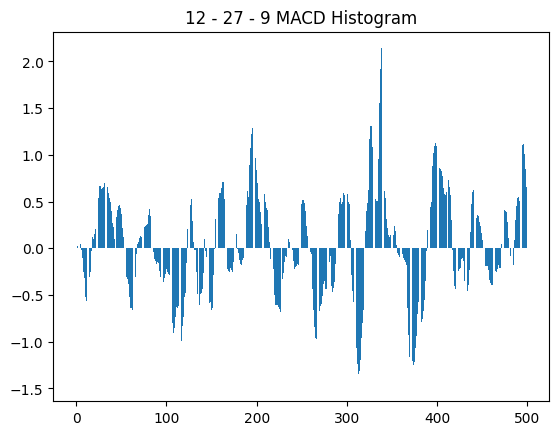

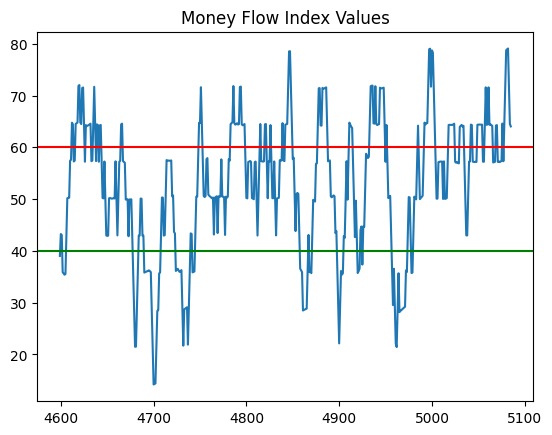

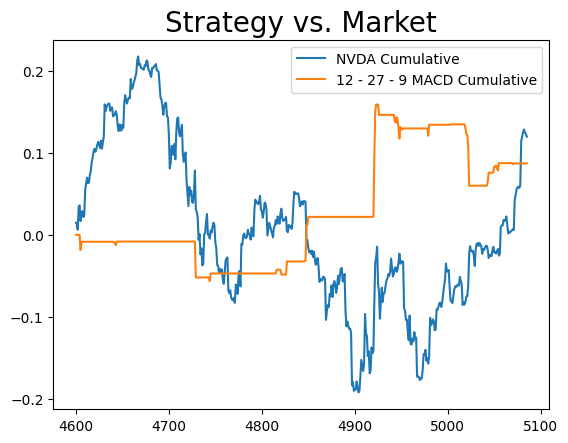

In [4]:
TICKER = 'NVDA'
INTERVAL='1h'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

MFI_LENGTH = 14
OVERBOUGHT = 60
OVERSOLD = 40
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# what subsetion of that data are you interested in
LOOKBACK = 500

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f'{fast}_ema'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span=slow).mean()

    # macd line is the difference betweent he fast and slow
    df[f'MACD'] = df[f'{fast}_ema'] - df[f'{slow}_ema']

    # macd signal is a 9-period moving average of this line
    df['Signal'] = df['MACD'].ewm(span=span).mean()

    # MACD histogram is almost always what is used in TA
    df['MACD_hist'] = df['MACD'] - df['Signal']

    # plot the histogram
    plt.bar(x=range(len(df)), height=df['MACD_hist'])
    plt.title(f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Histogram')

    return df

def add_MACD_strategy(df):

    df['MACD_Strategy'] = 0
    df['MACD_Strategy'] = np.where(df['MACD_hist'] > 0, 1, -1)
    df['MACD_Strategy'] = df['MACD_Strategy'].shift(1)
    return df

def add_MFI(df, length=MFI_LENGTH):

    df['Average_Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Money_Flow'] = df['Volume'] * df['Average_Price']
 
    # initialize empty flows
    df['Pos_Flow'] = 0
    df['Neg_Flow'] = 0

    df['Pos_Flow'] = np.where(df['Average_Price'].diff() > 0, df['Average_Price'], 0)
    df['Neg_Flow'] = np.where(df['Average_Price'].diff() < 0, df['Average_Price'], 0)

    mfr = df['Pos_Flow'].rolling(length).sum() / df['Neg_Flow'].rolling(length).sum()

    # add money flow column
    df['MFI'] = 100 - (100 / (1 + mfr))

    plt.figure()
    plt.plot(df['MFI'])
    plt.axhline(OVERBOUGHT, color='red')
    plt.axhline(OVERSOLD, color='green')
    plt.title('Money Flow Index Values');
        
    return df.dropna()

def add_MFI_strategy(df, overbought=OVERBOUGHT, oversold=OVERSOLD):

    df['MFI_Strategy'] = 0
    df['MFI_Strategy'] = np.where(df['MFI'] > overbought, -1, 
                     np.where(df['MFI'] < oversold, 1, 0))
    
    # shift back to make sure we have seen the signal
    df['MFI_Strategy'] = df['MFI_Strategy'].shift(1)
    return df

def add_full_strategy(df):

    df['Full_Strategy'] = df['MACD_Strategy'] + df['MFI_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1, 
                     np.where(df['Full_Strategy'] == -2, -1, 0))

    return df

def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative', f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Cumulative'])
    plt.title('Strategy vs. Market', size='20')

    return df

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_MFI(df)
    df = add_MACD_strategy(df)
    df = add_MFI_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)

    return df

df = main()
df